# Credit Card Fraud Detection - Model Development

## Objectives
- Build robust classical ML models for fraud detection
- Handle severe class imbalance
- Optimize for business metrics
- Compare multiple algorithms - Logistic Regression, Decision Tree, Random Forest, SVM
- Deploy best model with proper evaluation

## Challegnes identified from EDA
- Severe class imbalance
- PCA transformed features limit interpretability of data

In [1]:
# import libraries and insights from EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import warnings
warnings.filterwarnings("ignore")

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metric libraries

# Libraries to handle imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek

# Libraries for model development
from sklearn.utils.class_weight import compute_class_weight

print("Required libraries imported successfully!")

Required libraries imported successfully!


In [2]:
# Load dataset and insights from EDA
df = pd.read_csv('../data/creditcard.csv')
insights = json.load(open('../data/eda_insights.json'))

print("Dataset and insights loaded successfully!")

Dataset and insights loaded successfully!


In [3]:
# Extract key insights
with open('../data/eda_insights.json', 'r') as f:
    insights = json.load(f)

print("=== KEY INSIGHTS FROM EDA ===")
# Display insights
for key, value in insights.items():
    print(f"{key}: {value}")

=== KEY INSIGHTS FROM EDA ===
memory_usage_mb: 67.36
dataset_shape: [284807, 32]
imbalance_ratio: 577.88
fraud_rate: 0.17
missing_values: {}
duplicates_percentage: 0.379555277784605
top_15_features: ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V5', 'V2', 'V6']
significant_features: ['V14', 'V4', 'V12', 'V11', 'V10', 'V3', 'V2', 'V16', 'V9', 'V7', 'V17', 'V1', 'V6', 'V21', 'V18', 'V5', 'V27', 'V8', 'V19', 'V20', 'V28', 'Time', 'V24', 'Amount']
amount_stats: {'legitimate_mean': 88.29102242231328, 'fraudulent_mean': 122.21132113821139, 'max_transaction_amount': 25691.16, 'min_transaction_amount': 0.0, 'amount_std': 250.1201092401885}


In [4]:
# Feature preperation
print("=== FEATURE PREPARATION ===")

# Split dataset into features and target
X = df.drop(columns=['Class'])
y = df['Class']
print("\nFeatures and target variable separated successfully!")

# Consider only top 15 features based on EDA insights
top_features = insights['top_15_features']
X_selected = X[top_features]
print(f"\nSelected top {len(top_features)} features for modelling.")
print(f"\nSelected features: {', '.join(feature for feature in top_features)}")

=== FEATURE PREPARATION ===

Features and target variable separated successfully!

Selected top 15 features for modelling.

Selected features: V17, V14, V12, V10, V16, V3, V7, V11, V4, V18, V1, V9, V5, V2, V6


In [5]:
# Time based train-test split
print("\n=== TIME BASED TRAIN-TEST SPLIT ===")

# sort by 'Time' to ensure temporal order
df_sorted = df.sort_values(by='Time').reset_index(drop=True)
X_sorted = df_sorted[top_features]
y_sorted = df_sorted['Class']
print("\nDataset sorted by 'Time' for temporal split.")

# Split into train and test sets (First 80% train, Last 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_sorted, y_sorted, test_size=0.2, shuffle=False)
print("\nTrain-test split completed successfully!")

# print shapes of train and test sets
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train fraud rate: {y_train.mean() * 100:.2f}%, Test fraud rate: {y_test.mean() * 100:.2f}%")


=== TIME BASED TRAIN-TEST SPLIT ===

Dataset sorted by 'Time' for temporal split.

Train-test split completed successfully!

Train set shape: (227845, 15), Test set shape: (56962, 15)
Train fraud rate: 0.18%, Test fraud rate: 0.13%


In [6]:
# Feature scaling
print("\n=== FEATURE SCALING ===")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nFeature scaling completed using RobustScaler!")


=== FEATURE SCALING ===

Feature scaling completed using RobustScaler!


In [7]:
# Handling class imbalance
print("\n=== HANDLING CLASS IMBALANCE ===")

# Stratergy 1: Original class distribution
print("\nStrategy 1: Original class distribution")
print(f"Legitimate: {len(y_train[y_train==0])} ({len(y_train[y_train==0]) / len(y_train) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train[y_train==1])} ({len(y_train[y_train==1]) / len(y_train) * 100:.2f}%)")
# display(len(y_train[y_train==0]))

# Stratergy 2: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("\nStrategy 2: SMOTE applied")
print(f"Legitimate: {len(y_train_smote[y_train_smote==0])} ({len(y_train_smote[y_train_smote==0]) / len(y_train_smote) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train_smote[y_train_smote==1])} ({len(y_train_smote[y_train_smote==1]) / len(y_train_smote) * 100:.2f}%)")

# Stratergy 3: Borderline SMOTE
borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=5)

X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train_scaled, y_train)
print("\nStrategy 3: Borderline SMOTE applied")
print(f"Legitimate: {len(y_train_borderline_smote[y_train_borderline_smote==0])} ({len(y_train_borderline_smote[y_train_borderline_smote==0]) / len(y_train_borderline_smote) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train_borderline_smote[y_train_borderline_smote==1])} ({len(y_train_borderline_smote[y_train_borderline_smote==1]) / len(y_train_borderline_smote) * 100:.2f}%)")

# Stratergy 4: Undersampling + SMOTE combination
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)
print("\nStrategy 3: Undersampling + SMOTE applied")
print(f"Legitimate: {len(y_train_smote_tomek[y_train_smote_tomek==0])} ({len(y_train_smote_tomek[y_train_smote_tomek==0]) / len(y_train_smote_tomek) * 100:.2f}%)")
print(f"Fraudulent: {len(y_train_smote_tomek[y_train_smote_tomek==1])} ({len(y_train_smote_tomek[y_train_smote_tomek==1]) / len(y_train_smote_tomek) * 100:.2f}%)")


=== HANDLING CLASS IMBALANCE ===

Strategy 1: Original class distribution
Legitimate: 227428 (99.82%)
Fraudulent: 417 (0.18%)

Strategy 2: SMOTE applied
Legitimate: 227428 (50.00%)
Fraudulent: 227428 (50.00%)

Strategy 3: Borderline SMOTE applied
Legitimate: 227428 (50.00%)
Fraudulent: 227428 (50.00%)

Strategy 3: Undersampling + SMOTE applied
Legitimate: 227428 (50.00%)
Fraudulent: 227428 (50.00%)


In [14]:
# Model Development using samples from different stratergies
print("=== MODEL DEVELOPMENT ===")

# Compute class weights for cost-sensitive learning
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(y_train),
                                     y = y_train)
# display(class_weights)
class_weights_dict = {0: class_weights[0].round(2), 1: class_weights[1].round(2)}
print(f"\nComputed Class weights!")
print(f"Class weights: {class_weights_dict}")

# define models
models = {
    'Logistic Regression' : LogisticRegression(
        random_state = 42,
        class_weight = 'balanced',
        max_iter = 1000
    ),
    'Decision Tree' : DecisionTreeClassifier(
        random_state = 42,
        class_weight = 'balanced',
        max_depth = 10,
        min_samples_split = 100,
        min_samples_leaf = 50
    ),
    'Random Forest' : RandomForestClassifier(
        n_estimators = 100,
        random_state = 42,
        class_weight = 'balanced',
        max_depth = 10,
        min_samples_split = 100,
        min_samples_leaf = 50,
        n_jobs = -1
    )#,
    # 'SVM' : SVC(
    #     random_state = 42,
    #     class_weight = 'balanced',
    #     kernel = 'rbf',
    #     probability = True
    # )

    # Ignoring SVM
}

print(f"\nInitialized {len(models)} classical ML models.")

=== MODEL DEVELOPMENT ===

Computed Class weights!
Class weights: {0: np.float64(0.5), 1: np.float64(273.2)}

Initialized 3 classical ML models.


### Important:

Ignored SVM because:
- The data obtained from oversampling techniques is really really huge, around 2.5lakh datapoints for 31 variables for each class.
- Running an SVM on such large dataset, that too with RBF Kernel, for 5 Fold Cross Validation is computationally intensive
- Initially, I hadn't thought about this - ran the model, but even after 9 hours of training, I couldn't complete 5 Fold CV using SVM for data from SMOTE oversampling.
- This lead me to realise that it was an impractical approach, hence cancelling the training task late at night.
- Key takeaway from this mistake is that - using SVM on really large datasets like this one is not favourable.
- So I will be continuing with only 3 models - Logistic Regression, Decision Tree and Random Forests.

In [9]:
# Initiate Cross Validation to ensure stable and reliable results
print("=== CROSS VALIDATION SETUP ===")

# Initiate Stratified K Fold Cross Validation (maintains class distribution)
k = 5
cv_stratergy = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# define a function to get CV performance metrics
def evaluate_model_cv(model, X, y, cv_stratergy, scoring_metrics):
    results = {}
    for metric in scoring_metrics:
        scores = cross_val_score(model, X, y, cv = cv_stratergy, scoring = metric, n_jobs = -1)
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    return results

# list out scoring metrics appropriate for imbalanced datasets
scoring_metrics = ['precision', 'recall', 'f1', 'roc_auc', 'average_precision']

print("\nCross validation strategy configured!")
print(f"Used Stratified {k} fold cross validation with metrics {scoring_metrics}")


=== CROSS VALIDATION SETUP ===

Cross validation strategy configured!
Used Stratified 5 fold cross validation with metrics ['precision', 'recall', 'f1', 'roc_auc', 'average_precision']


In [15]:
# Model Training and Evaluation
print("=== MODEL TRAINING AND EVALUATION ===")

# store results from different models
results_comparision = {}

# different sampling strategies
sampling_strategies = {
    'Original': (X_train_scaled, y_train),
    'SMOTE': (X_train_smote, y_train_smote),
    'Borderline_SMOTE': (X_train_borderline_smote, y_train_borderline_smote),
    'SMOTE_Tomek': (X_train_smote_tomek, y_train_smote_tomek)
}

# run a loop for all the strategies and for all the models
for strategy, (X_train, y_train) in sampling_strategies.items():
    print(f"\n=== EVALUATING WITH {strategy.upper()} STRATEGY ===")
    
    results_comparision[strategy] = {}

    # evaluate for each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # evaluate CV results
        cv_results = evaluate_model_cv(model, X_train, y_train, cv_stratergy, scoring_metrics)
        results_comparision[strategy][model_name] = cv_results

        # print results
        print(f"\nModel: {model_name}")
        for metric,values in cv_results.items():
            print(f"Metric: {metric} : {values['mean']:.4f} ({values['std']:.4f})")

=== MODEL TRAINING AND EVALUATION ===

=== EVALUATING WITH ORIGINAL STRATEGY ===

Training Logistic Regression...

Model: Logistic Regression
Metric: precision : 0.0672 (0.0016)
Metric: recall : 0.8970 (0.0315)
Metric: f1 : 0.1251 (0.0029)
Metric: roc_auc : 0.9732 (0.0075)
Metric: average_precision : 0.7288 (0.0184)

Training Decision Tree...

Model: Decision Tree
Metric: precision : 0.1089 (0.0244)
Metric: recall : 0.8512 (0.0228)
Metric: f1 : 0.1923 (0.0391)
Metric: roc_auc : 0.9243 (0.0118)
Metric: average_precision : 0.7332 (0.0529)

Training Random Forest...

Model: Random Forest
Metric: precision : 0.7153 (0.0355)
Metric: recall : 0.8538 (0.0173)
Metric: f1 : 0.7779 (0.0235)
Metric: roc_auc : 0.9771 (0.0089)
Metric: average_precision : 0.8005 (0.0149)

=== EVALUATING WITH SMOTE STRATEGY ===

Training Logistic Regression...

Model: Logistic Regression
Metric: precision : 0.9736 (0.0008)
Metric: recall : 0.8989 (0.0011)
Metric: f1 : 0.9348 (0.0005)
Metric: roc_auc : 0.9836 (0.0006)

The training for SVM has taken too long, about 9 hours till now to run cross validation for SMOTE dataset with SVM. This proves the fact that SVM is not efficient of preferable for large dataset with very high dimension. So it's better to ignore SVM in such cases.

In [11]:
# print(results_comparision)
results_comparision_df = pd.DataFrame(results_comparision)
print(results_comparision_df)

# exporting the results temproarily to a csv file
results_comparision_df.to_csv("results_comparision.csv")

Empty DataFrame
Columns: []
Index: []


In [16]:
# Continuing with the workflow today!

In [17]:
print(results_comparision)

{'Original': {'Logistic Regression': {'precision': {'mean': np.float64(0.0672375375627486), 'std': np.float64(0.0016170209137248259), 'scores': array([0.06636364, 0.06875544, 0.06465517, 0.06906077, 0.06735267])}, 'recall': {'mean': np.float64(0.8969879518072288), 'std': np.float64(0.031492715241939535), 'scores': array([0.87951807, 0.95180723, 0.90361446, 0.89285714, 0.85714286])}, 'f1': {'mean': np.float64(0.12508685990007395), 'std': np.float64(0.002898247809637607), 'scores': array([0.12341505, 0.12824675, 0.12067578, 0.12820513, 0.12489159])}, 'roc_auc': {'mean': np.float64(0.9731744792796272), 'std': np.float64(0.00749930278545217), 'scores': array([0.96614263, 0.98518517, 0.96592914, 0.97028089, 0.97833456])}, 'average_precision': {'mean': np.float64(0.7288392286650859), 'std': np.float64(0.018390142658239066), 'scores': array([0.74340734, 0.73931366, 0.73986691, 0.69352837, 0.72807986])}}, 'Decision Tree': {'precision': {'mean': np.float64(0.10890828802041903), 'std': np.float6

In [20]:
# Results Visualization
print("=== RESULTS VISUALIZATION ===")

# Create a dataframe to visualize the results
results_df = []
for strategy in results_comparision:
    for model in results_comparision[strategy]:
        for metric in results_comparision[strategy][model]:
            results_df.append(
                {
                    'Strategy': strategy,
                    'Model': model,
                    'Metric': metric,
                    'Score': results_comparision[strategy][model][metric]['mean'],
                    'Std': results_comparision[strategy][model][metric]['std']
                }
            )
results_df = pd.DataFrame(results_df)
display(results_df)

=== RESULTS VISUALIZATION ===


,Strategy,Model,Metric,Score,Std
0,Original,Logistic Regression,precision,0.067238,0.001617
1,Original,Logistic Regression,recall,0.896988,0.031493
2,Original,Logistic Regression,f1,0.125087,0.002898
3,Original,Logistic Regression,roc_auc,0.973174,0.007499
4,Original,Logistic Regression,average_precision,0.728839,0.018390
5,Original,Decision Tree,precision,0.108908,0.024362
6,Original,Decision Tree,recall,0.851234,0.022800
7,Original,Decision Tree,f1,0.192300,0.039150
8,Original,Decision Tree,roc_auc,0.924290,0.011779
9,Original,Decision Tree,average_precision,0.733235,0.052927


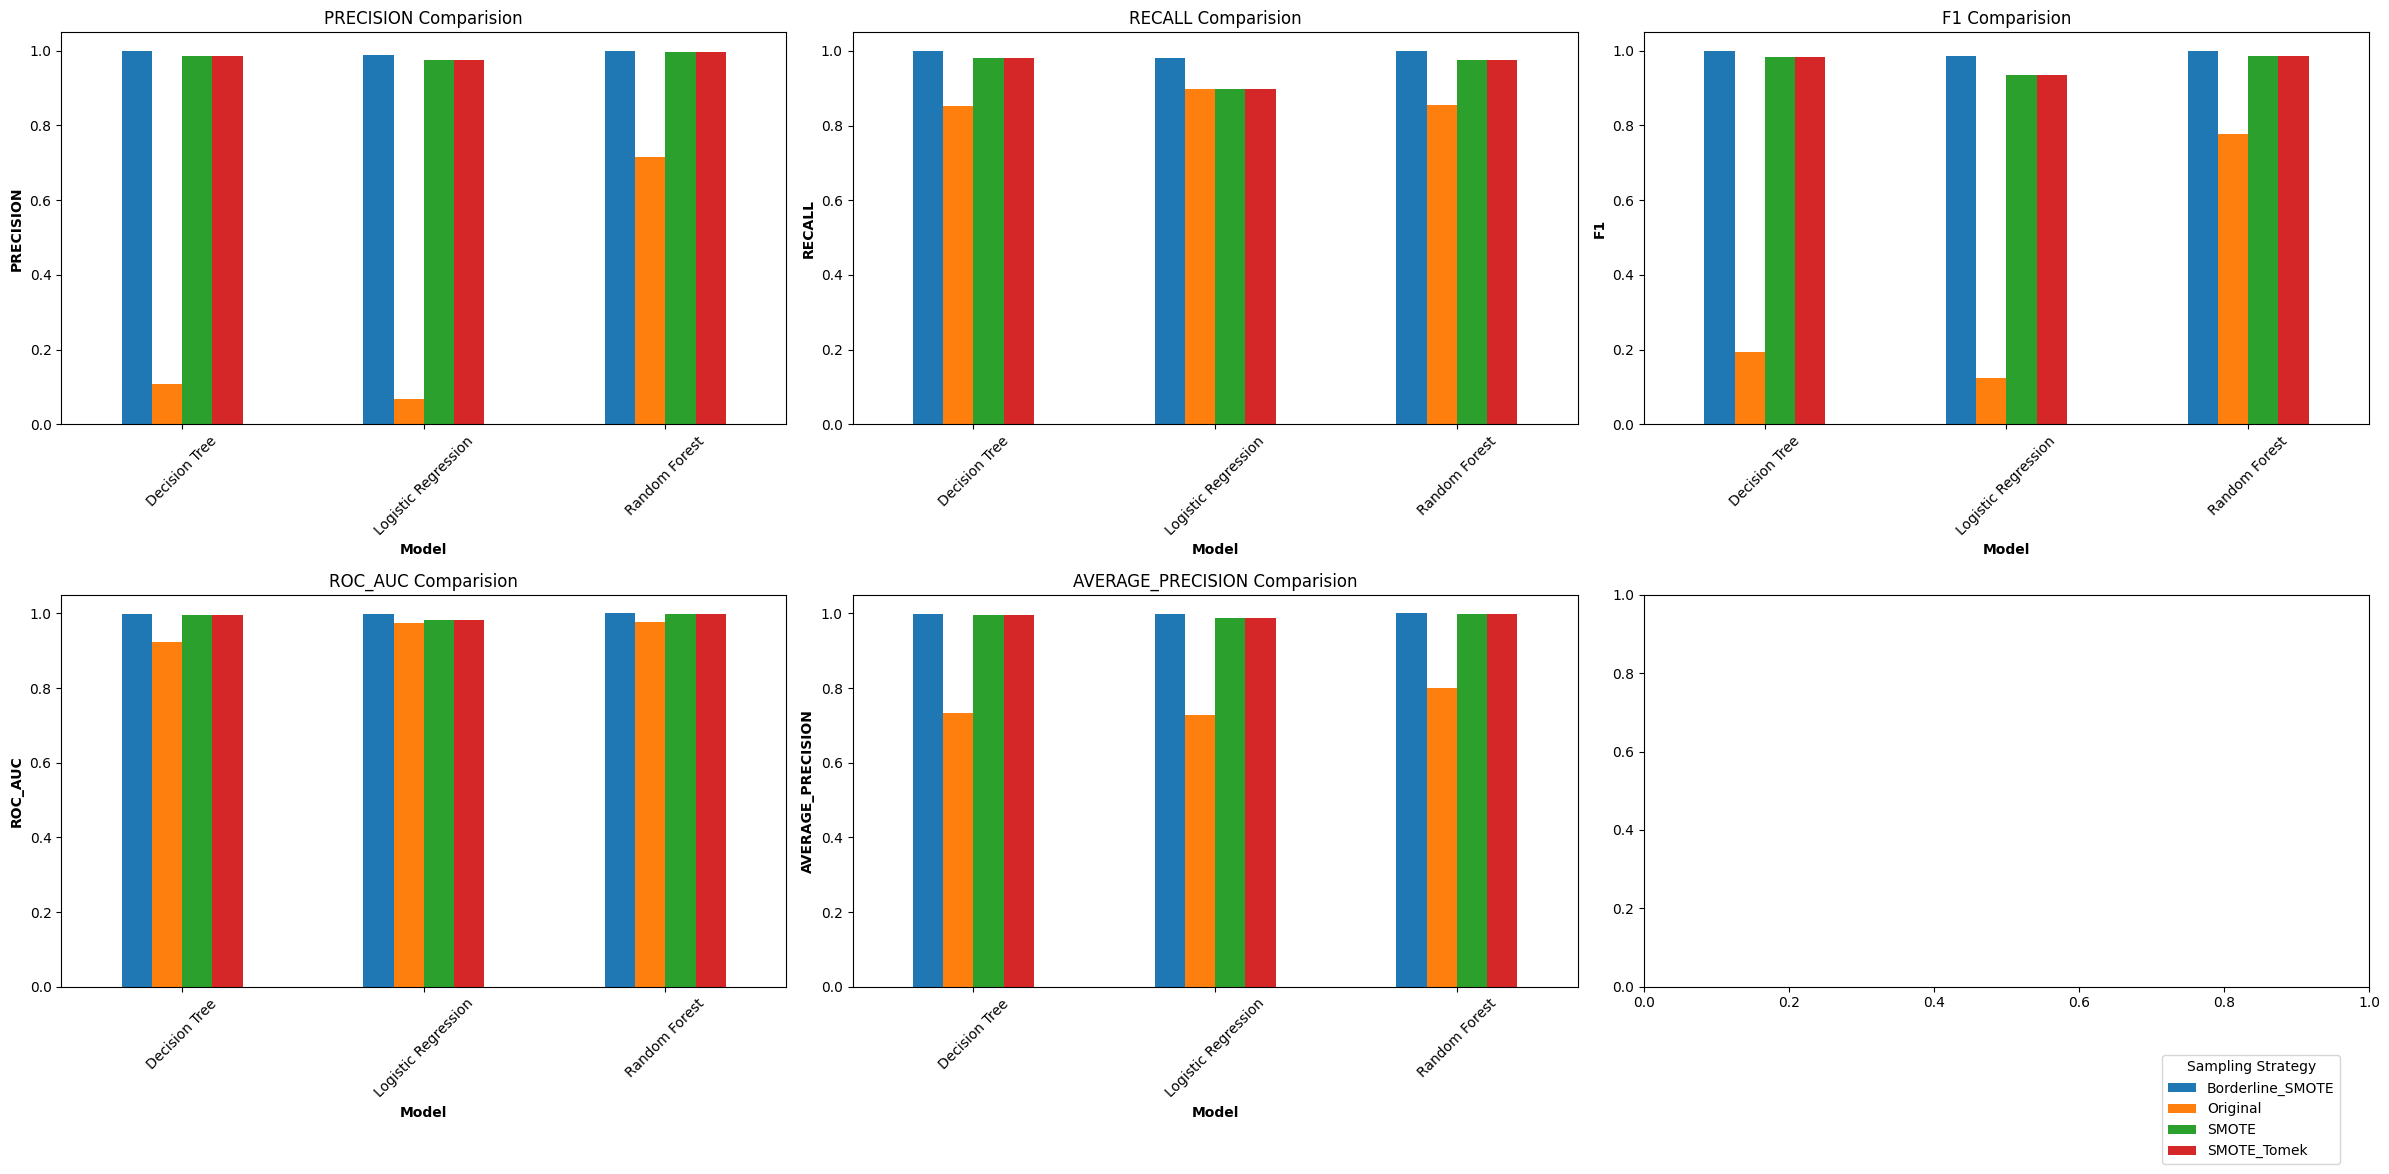

In [ ]:
# Plot for visualization
fig,axes = plt.subplots(2,3,figsize=(24,12))

metrics_to_plot = ['precision','recall','f1','roc_auc','average_precision']

for i,metric in enumerate(metrics_to_plot):
    pivot_data = results_df[results_df['Metric'] == metric].pivot(
            index='Model', columns='Strategy', values='Score'
        )
    # display(pivot_data)
    pivot_data.plot(kind='bar', ax = axes[i//3, i%3], title = f"{metric.upper()} Comparision",legend=False)
    axes[i//3, i%3].set_xlabel("Model",fontweight="bold")
    axes[i//3, i%3].set_ylabel(metric.upper(),fontweight="bold")
    # axes[i//3, i%3].legend(title="Sampling Strategy",loc='upper left')
    axes[i//3, i%3].tick_params(axis = 'x', rotation=45)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Sampling Strategy", loc='lower right', bbox_to_anchor=(0.98, 0.02))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [61]:
# pivot_data = results_df[results_df['Metric'] == 'f1'].pivot(
#             index='Model', columns='Strategy', values='Score'
#         )
# pivot_data

In [81]:
# Hyperparameter Tuning

print("=== HYPERPARAMETER TUNING ===")

# Select best performing strategy and model based on f1 score
f1_results = results_df[results_df['Metric']=='f1'].pivot(index = 'Model', columns = 'Strategy', values = 'Score')
f1_results = f1_results.round(4)
print("\nF1-Score Comparision across different strategies and models")
display(f1_results)

# extract best strategy and models
best_strategy = f1_results.mean().idxmax()
best_models = f1_results[best_strategy].nlargest(2).index.tolist()
print(f"Best Strategy: {best_strategy}")
print(f"Best {len(best_models)} Models: {', '.join(best_models)}")

print("\nGetting data for best strategy...")
X_best, y_best = sampling_strategies[best_strategy]

=== HYPERPARAMETER TUNING ===

F1-Score Comparision across different strategies and models


Strategy,Borderline_SMOTE,Original,SMOTE,SMOTE_Tomek
Model,,,,
Decision Tree,0.9987,0.1923,0.9828,0.9828
Logistic Regression,0.9853,0.1251,0.9348,0.9348
Random Forest,0.9994,0.7779,0.9851,0.9851


Best Strategy: Borderline_SMOTE
Best 2 Models: Random Forest, Decision Tree

Getting data for best strategy...


In [82]:
# sampling_strategies